# Module 4 Capstone — Unsupervised Learning & Anomaly Detection

**Guided, instructor-led lab**.

All code is provided.
We will:
- run each section together
- interpret outputs as a group
- adjust selected parameters to observe different behaviors

There is **no single correct answer**.
The goal is to reason about trade-offs, uncertainty, and context.


### Learning Goals

By the end of this capstone, you should be able to:
- explore structure in unlabeled data
- compare clustering and anomaly detection methods
- use dimensionality reduction as a diagnostic tool
- reason about false positives vs false negatives
- justify model choices based on application context


## Step 0 — Setup & Load Data

We will work with **synthetic datasets** designed to mirror real-world scenarios:

- **Fraud-like transactions**  
  Rare anomalies, subtle patterns, delayed labels.

- **Customer-like behavior data**  
  Higher-dimensional structure with noise and outliers.

⚠️ **Important:**  
Although ground-truth labels exist for the fraud dataset, we're not going to use those, at least not initially. Our goal in this section is to explore unsupervised learning. 


In [ ]:
# --- Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_score, recall_score, f1_score

# Dataset helper functions
from 04_99_datasets_synth.py import make_fraud_synth, make_high_dim_synth

# Consistent seed
SEED = 1955
np.random.seed(SEED)


In [2]:
# Load datasets
df_fraud, fraud_labels_hidden = make_fraud_synth(seed=SEED)
df_customers = make_high_dim_synth(seed=SEED)

print("Fraud dataset shape:", df_fraud.shape)
print("Customer dataset shape:", df_customers.shape)

df_fraud.head()


Fraud dataset shape: (2000, 6)
Customer dataset shape: (600, 6)


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5
0,-0.097774,-0.081522,1.964090,-0.637891,-0.421043,1.798991
1,-0.298693,-0.330910,-1.466452,-1.060129,-0.467623,0.526437
2,2.042000,-0.305821,-0.548890,-0.232416,0.171210,-0.429921
3,-0.480770,-1.217748,-1.096023,NaN,0.791659,-0.967756
4,1.706993,1.290789,-0.086142,0.580022,0.268947,0.935176


### Understanding the Datasets

- **`df_fraud`**
  - Each row represents a transaction
  - Most transactions are normal
  - A small fraction are anomalous
  - Labels are hidden for now

- **`df_customers`**
  - Each row represents a customer profile
  - No ground-truth labels exist
  - Structure and outliers must be inferred

Both datasets intentionally include:
- missing values
- noise
- imperfect structure

This mirrors the ambiguity of real unsupervised learning problems.


### Orienting Ourselves in the Data

This output confirms that both datasets loaded correctly:

- **Fraud dataset:** 2,000 observations × 6 features  
- **Customer dataset:** 600 observations × 6 features  

Each row represents a single observation described by multiple numeric features.
At this stage:

- There are **no labels** visible
- Feature values vary across dimensions
- Missing values are present
- Nothing in the table clearly identifies “fraud” or “anomaly”

This is intentional.

In real unsupervised settings, anomalies rarely announce themselves
through obvious thresholds or single features.

At this point, our task is **not to decide** what is anomalous,
but to begin **exploring structure** using different methods.


### What’s Next

In **Step 1**, we will begin with **exploratory clustering**:
- apply K-Means and DBSCAN
- visualize results
- discuss whether apparent structure is meaningful

At each step, we will pause to interpret what the models suggest —
and what they do *not* tell us.


## Step 1 — Clustering (Exploratory)

We begin with **exploration**, not judgment.

At this stage:
- there are **no labels**
- there is **no ground truth**
- clusters are hypotheses, not answers

Our goal is to see whether *any* structure emerges — and how sensitive it is.


In [3]:
# Preprocessing (temporary and minimal)
# - Handle missing values
# - Scale features for distance-based methods

X = df_fraud.copy()
X = X.fillna(X.mean())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled.shape


(2000, 6)

We apply **simple preprocessing**:
- missing values are filled with column means
- features are scaled so no single feature dominates distance

This preprocessing is **not optimized** — it is only meant to support exploration.


In [4]:
# ==============================
# 🔧 TUNABLE PARAMETERS
# (Safe to modify during class)
# ==============================

k = 3            # Try: 2, 4, 5
eps = 0.6        # Try: 0.3 or 1.0
min_samples = 8  # Try: 5 or 15


In [5]:
# K-Means clustering
kmeans = KMeans(n_clusters=k, random_state=SEED)
kmeans_labels = kmeans.fit_predict(X_scaled)

# DBSCAN clustering
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(X_scaled)

# How many points labeled as noise?
num_noise = (dbscan_labels == -1).sum()
num_noise


np.int64(2000)

### Running the First Clustering Methods

In this step, we applied **two different clustering approaches** to the same data:

- **K-Means**
  - Assigns every point to one of `k` clusters
- **DBSCAN**
  - Forms clusters based on density
  - Allows some points to be labeled as **noise**

The value printed above shows **how many points DBSCAN labeled as noise**
under the current parameter settings.

At this stage:
- we have not judged whether these clusters are “good” or “bad”
- we have not used any labels
- we are simply preparing results for **visual inspection**

The next step is to **look at these assignments visually**
and ask whether they align with intuition.

In this case, DBSCAN labeled *all* points as noise, indicating that the current
parameter settings are too strict to identify dense regions in this dataset.

DBSCAN explicitly labels **noise points** (label = -1).

The number of noise points depends strongly on `eps` and `min_samples`.
This is expected — and unavoidable.


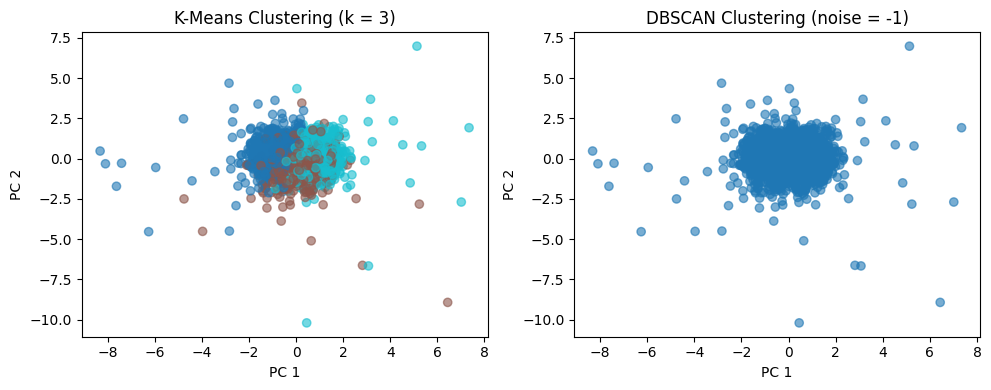

In [6]:
# PCA for visualization only
pca = PCA(n_components=2, random_state=SEED)
X_pca = pca.fit_transform(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=kmeans_labels,
    cmap="tab10",
    alpha=0.6
)
axes[0].set_title(f"K-Means Clustering (k = {k})")
axes[0].set_xlabel("PC 1")
axes[0].set_ylabel("PC 2")

axes[1].scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=dbscan_labels,
    cmap="tab10",
    alpha=0.6
)
axes[1].set_title("DBSCAN Clustering (noise = -1)")
axes[1].set_xlabel("PC 1")
axes[1].set_ylabel("PC 2")

plt.tight_layout()
plt.show()


### Interpreting the Step 1 Clustering Results

This figure compares **K-Means** and **DBSCAN** applied to the *same data*
using the *same PCA projection* for visualization.

#### What to notice

- **K-Means (left)**
  - Divides the data into `k = 3` clusters
  - Every point is assigned to a cluster
  - Cluster boundaries exist even where the data looks continuous

- **DBSCAN (right)**
  - All points are labeled as **noise** under the current parameters
  - No clusters are formed
  - The algorithm is effectively saying:
    > “I do not see any regions dense enough to justify a cluster.”

This is not a failure — it is a **statement about assumptions**.

#### Why this happens

- K-Means *always* produces clusters, because it is required to do so
- DBSCAN only produces clusters when density thresholds are met

With the current `eps` and `min_samples` values:
- DBSCAN’s density requirement is too strict for this dataset
- As a result, it refuses to group any points

#### What this tells us (before changing anything)

This comparison highlights an important idea:

> Different clustering methods can give **radically different answers**
> even when applied to the same data.

At this stage:
- K-Means suggests structure exists
- DBSCAN suggests structure is uncertain

Neither answer is “correct” yet.

#### ⏸ STOP & DISCUSS

- If this were a real problem, which result would you trust *mo*


### Transition

Clustering gives us **one lens** on the data.

In the next step, we will use **dimensionality reduction**
to better understand whether these clusters and noise points
reflect meaningful structure — or visual artifacts.


## Step 2 — Dimensionality Reduction for Visualization

Clustering algorithms operate in **high-dimensional space**,
but humans reason visually.

Dimensionality reduction lets us *inspect* structure —
but it can also **distort** it.

In this step, we use dimensionality reduction as a **diagnostic tool**, not a judge.


In [7]:
# PCA projection (2D) — stable, linear
pca = PCA(n_components=2, random_state=SEED)
X_pca = pca.fit_transform(X_scaled)

# Explained variance
pca.explained_variance_ratio_


array([0.18897579, 0.17805404])

### Understanding the PCA Projection

PCA projects the high-dimensional data into two new axes:
- **PC 1** captures the largest source of variance
- **PC 2** captures the second-largest, orthogonal source of variance

The values printed above show the **fraction of total variance**
explained by each component.

#### What to notice

- PC 1 explains about **19%** of the total variance
- PC 2 explains about **18%** of the total variance
- Together, the 2D projection captures **less than 40%** of the total variation

This tells us that:
- the data’s structure is spread across many dimensions
- no single 2D view can fully represent the dataset

At this stage, PCA is being used as a **visual diagnostic tool**, not as a model.


### Interpreting PCA

- PCA preserves **global variance**, not cluster labels
- If clusters separate cleanly here, structure may be strong
- If clusters overlap heavily, separation may be weak or artificial

Explained variance tells us how much information we retained —
but not whether clusters are meaningful.


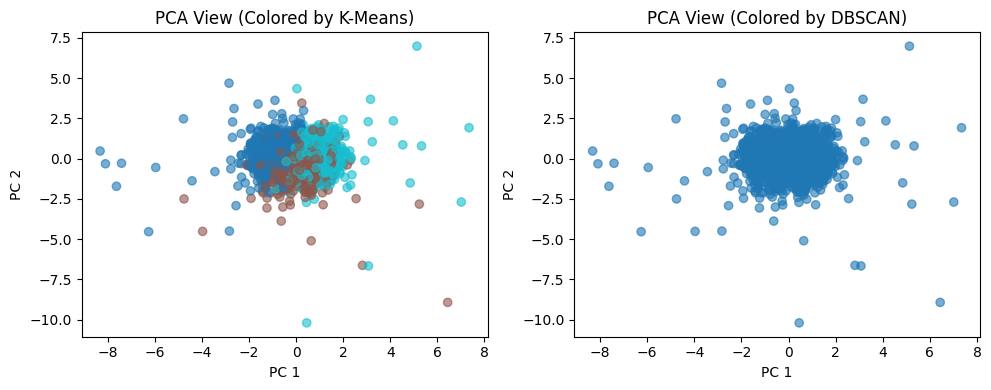

In [8]:
# Visualize PCA projection with clustering overlays
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=kmeans_labels,
    cmap="tab10",
    alpha=0.6
)
axes[0].set_title("PCA View (Colored by K-Means)")
axes[0].set_xlabel("PC 1")
axes[0].set_ylabel("PC 2")

axes[1].scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=dbscan_labels,
    cmap="tab10",
    alpha=0.6
)
axes[1].set_title("PCA View (Colored by DBSCAN)")
axes[1].set_xlabel("PC 1")
axes[1].set_ylabel("PC 2")

plt.tight_layout()
plt.show()


### Interpreting the PCA View with Cluster Overlays

These plots show the **same PCA projection**, colored by the cluster assignments
from two different methods:

- **Left:** K-Means cluster labels
- **Right:** DBSCAN cluster / noise labels

This allows us to compare how each method’s decisions
appear when viewed in a shared 2D space.

#### What to notice

- **K-Means (left)**
  - The PCA space is divided into colored regions
  - Cluster boundaries appear even where points overlap heavily
  - Every point is assigned to a cluster

- **DBSCAN (right)**
  - All points appear in a single color
  - Under the current parameters, DBSCAN treats all points as noise
  - PCA does not reveal any dense regions that DBSCAN is willing to accept

#### Why this matters

This comparison reinforces two important ideas:

1. **PCA does not create structure**  
   It only reveals variance. If structure is subtle or distributed,
   PCA may show heavy overlap even when algorithms behave differently.

2. **Clustering decisions depend on assumptions**  
   - K-Means enforces structure
   - DBSCAN requires sufficient density

Both interpretations are consistent with the same PCA view.

#### Lab takeaway

At this point:
- PCA has not resolved the disagreement between methods
- Visualization has helped us *understand* the disagreement, not eliminate it

In the next step, we will try a **nonlinear visualization method**
to see whether local structure becomes more apparent.


### Interpreting t-SNE

t-SNE is designed to preserve **local neighborhoods**, not distances.

Important caveats:
- cluster separation can be exaggerated
- global geometry is unreliable
- different runs or parameters can change the picture

t-SNE is best used to **suggest hypotheses**, not confirm them.


In [9]:
# ==============================
# 🔧 TUNABLE PARAMETERS (t-SNE)
# ==============================
perplexity = 30     # Try: 10 or 50


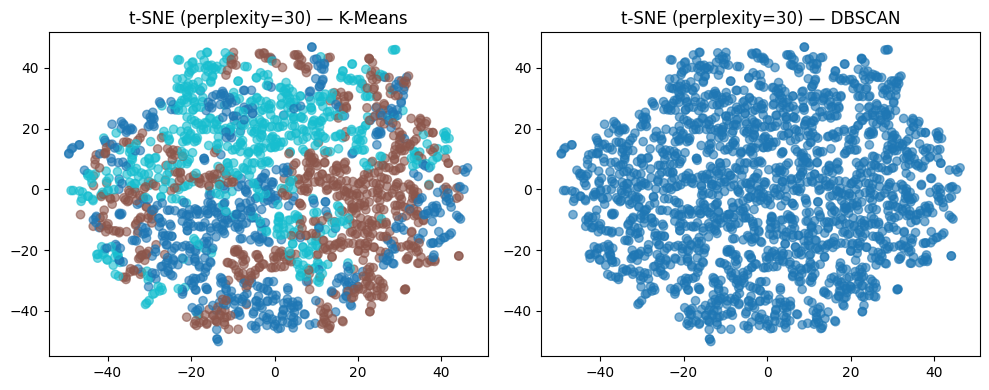

In [10]:
# t-SNE projection — nonlinear, visualization only
tsne = TSNE(
    n_components=2,
    perplexity=perplexity,
    learning_rate="auto",
    init="random",
    random_state=SEED
)
X_tsne = tsne.fit_transform(X_scaled)

# Visualize t-SNE with clustering overlays
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].scatter(
    X_tsne[:, 0], X_tsne[:, 1],
    c=kmeans_labels,
    cmap="tab10",
    alpha=0.6
)
axes[0].set_title(f"t-SNE (perplexity={perplexity}) — K-Means")

axes[1].scatter(
    X_tsne[:, 0], X_tsne[:, 1],
    c=dbscan_labels,
    cmap="tab10",
    alpha=0.6
)
axes[1].set_title(f"t-SNE (perplexity={perplexity}) — DBSCAN")

plt.tight_layout()
plt.show()


### Interpreting the t-SNE Projection (Nonlinear Visualization)

These plots show a **t-SNE projection** of the same data,
colored by cluster assignments from:

- **Left:** K-Means  
- **Right:** DBSCAN  

t-SNE is a **nonlinear visualization method** designed to preserve
*local neighborhoods*, not global geometry.

#### What to notice

- **K-Means (left)**
  - Points appear split into visually distinct regions
  - Local groupings seem more pronounced than in the PCA view
  - Clusters look more separated, even where PCA showed heavy overlap

- **DBSCAN (right)**
  - All points appear as a single group
  - DBSCAN still does not identify dense regions under current parameters
  - t-SNE does *not* “force” DBSCAN to see clusters

At first glance, t-SNE may make the K-Means result look more convincing.

#### Why this can be misleading

t-SNE:
- emphasizes **local similarity**
- distorts global distances
- can exaggerate separation between nearby groups

As a result:
- visually separated regions may not represent stable clusters
- apparent gaps may be artifacts of the projection
- different parameter choices can change the picture significantly

This is why t-SNE is described as **visualization-only**.

#### Lab takeaway

Comparing PCA and t-SNE teaches an important lesson:

> Visualization can change how *confident* we feel —  
> without changing the underlying data.

At this stage:
- PCA suggested ambiguity
- t-SNE suggests local structure
- clustering methods still disagree

Rather than resolving uncertainty, t-SNE helps us
**ask better questions** about it.

In the next step, we will move beyond visualization
and apply **explicit anomaly detection models**
to see how different definitions of “unusual” behave.


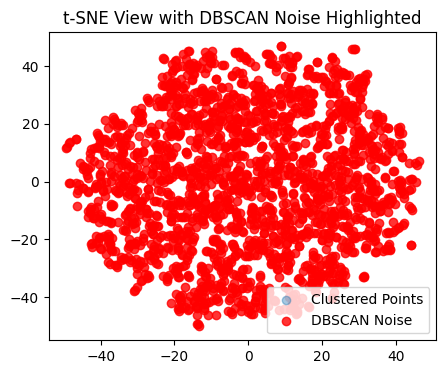

In [11]:
# Highlight DBSCAN noise points in t-SNE space
noise_mask = dbscan_labels == -1

plt.figure(figsize=(5, 4))
plt.scatter(
    X_tsne[~noise_mask, 0],
    X_tsne[~noise_mask, 1],
    alpha=0.4,
    label="Clustered Points"
)
plt.scatter(
    X_tsne[noise_mask, 0],
    X_tsne[noise_mask, 1],
    c="red",
    alpha=0.8,
    label="DBSCAN Noise"
)
plt.title("t-SNE View with DBSCAN Noise Highlighted")
plt.legend()
plt.show()


### Interpreting DBSCAN Noise in t-SNE Space

This plot highlights **DBSCAN noise points** in the **t-SNE projection**.

- **Red points** are observations labeled as *noise* by DBSCAN  
- **Blue points** represent observations that DBSCAN grouped together  
  (under the current parameter settings)

t-SNE is used here **only for visualization**.
DBSCAN’s decisions were made in the original feature space.

#### What to notice

- Almost **all points are labeled as noise**
- Noise points are spread **throughout the t-SNE space**
- There are no clear dense regions that DBSCAN is willing to accept
- t-SNE does *not* make DBSCAN suddenly “see” clusters

Even though t-SNE shows local neighborhoods,
DBSCAN still refuses to group points under the current assumptions.

#### Why this is an important result

This reinforces a critical lesson:

> **Visualization cannot override model assumptions.**

- t-SNE may suggest local structure
- DBSCAN requires sufficient density to form clusters
- If that density is not present (or parameters are too strict),
  DBSCAN will continue to label points as noise

This outcome is not an error —
it is DBSCAN being **explicit about uncertainty**.

#### Lab takeaway

At the end of Step 2:
- Visualization has helped us *understand disagreement*
- It has **not resolved** that disagreement
- We still cannot confidently say which points are unusual

This is exactly the point where **anomaly detection models**
become useful: they provide *explicit scores* rather than clusters.

In the next step, we will apply anomaly detection methods
to prioritize observations for further investigation.


### What to Notice About Noise

- Some noise points appear isolated
- Others sit near dense regions
- Visual isolation does **not** guarantee true anomaly

This reinforces why **multiple methods** are needed.


### STOP & DISCUSS — What Have We Learned So Far?

At this point in the lab:

- Visualization methods disagree
- Clustering methods give conflicting answers
- DBSCAN is explicitly refusing to group points
- No method has confidently identified “unusual” behavior

Discuss briefly:

- What *kind* of uncertainty are we facing here?
- Is it better to:
  - force structure?
  - admit uncertainty?
  - change assumptions?
- If you had to act now, what would you do next?

This pause marks a shift in strategy:
instead of asking *“How should we group points?”*  
we now ask *“Which points deserve closer attention?”*


### Transition

We have explored structure and visualized it —
but clustering alone does not answer the anomaly question.

Next, we apply **dedicated anomaly detection models**
that explicitly score how *unusual* each point is.


## Step 3 — Anomaly Detection Models

Clustering suggests **structure**, but it does not directly answer:
> *Which points are truly unusual?*

Anomaly detection models assign **scores** or **decisions**
based on different assumptions about what “normal” looks like.


In [18]:
# ==============================
# 🔧 TUNABLE PARAMETERS
# (Safe to modify during class)
# ==============================

# Expected fraction of anomalies
contamination = 0.03   # Try: 0.01 or 0.05

# One-Class SVM boundary tightness
nu = 0.03              # Try: 0.01 or 0.08


In [19]:
# Isolation Forest — isolation-based anomaly detection
iso = IsolationForest(
    n_estimators=200,
    contamination=contamination,
    random_state=SEED
)

iso_preds = iso.fit_predict(X_scaled)   # -1 = anomaly, 1 = normal
iso_scores = iso.decision_function(X_scaled)

iso_preds[:10], iso_scores[:10]


(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([0.07372201, 0.11621949, 0.10974135, 0.1179337 , 0.09736949,
        0.08617205, 0.1028472 , 0.10709675, 0.09325333, 0.08554679]))

### Interpreting the First Anomaly Detection Output

This output shows two things for the **first few observations**:

1. **Binary predictions**
2. **Continuous anomaly scores**

#### Binary predictions

The first array contains values of `1` or `-1`:

- `1` → classified as *normal*
- `-1` → classified as *anomalous*

At this point, all of the first few observations are labeled as **normal**.
This does **not** mean there are no anomalies in the data.

It simply means that **no decision threshold has been applied yet**.

#### Anomaly scores

The second array contains **anomaly scores** produced by Isolation Forest.

Key ideas:
- Lower scores indicate observations that are *more unusual*
- Higher scores indicate observations that are *more typical*
- These values are **relative**, not absolute

At this stage:
- we are *ranking* observations by how unusual they appear
- we are **not yet deciding** which ones are anomalies

#### Lab takeaway

Anomaly detection models do **not** immediately answer:
> “Is this point an anomaly?”

They first answer:
> “How unusual is this point compared to others?”

In the next step, we will **visualize these scores**
and explore how choosing a threshold changes which points are flagged.


In [20]:
# One-Class SVM — boundary-based anomaly detection
ocsvm = OneClassSVM(
    nu=nu,
    kernel="rbf",
    gamma="scale"
)

svm_preds = ocsvm.fit_predict(X_scaled)  # -1 = anomaly, 1 = normal

svm_preds[:10]


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

### Interpreting the One-Class SVM Output

This output shows the **initial predictions** from a One-Class SVM
for the first few observations.

- `1` indicates a point classified as *normal*
- `-1` would indicate a point classified as *anomalous*

At this stage, all of the first few observations are labeled as **normal**.

#### What this means

One-Class SVM works by learning a **boundary around typical behavior**.
Points that fall *outside* this boundary are considered anomalous.

Under the current parameter settings:
- the boundary is relatively **broad**
- these observations fall comfortably inside it

This does **not** imply that anomalies do not exist —
only that the model is being **conservative** so far.

#### Lab takeaway

Just like Isolation Forest:
- One-Class SVM produces a *decision based on assumptions*
- Those assumptions are controlled by parameters

Different models — even when applied to the same data —
can disagree simply because they define “normal” differently.

In the next step, we will **visualize the One-Class SVM results**
and compare them to the Isolation Forest output.


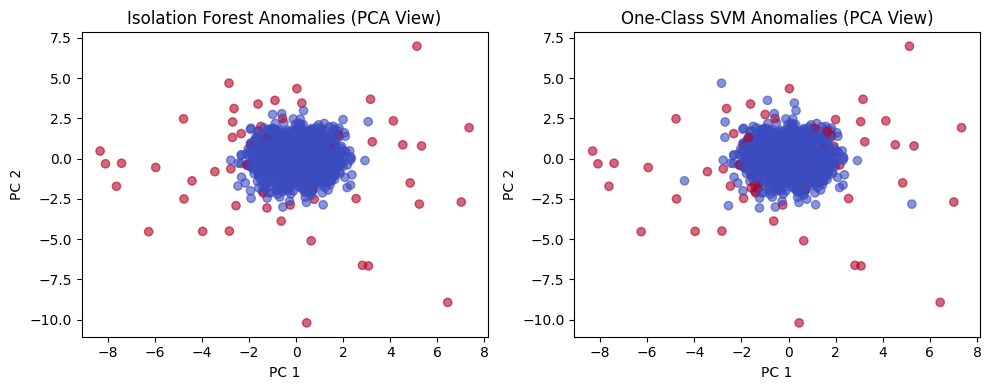

In [21]:
# Visualize anomalies in PCA space
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=(iso_preds == -1),
    cmap="coolwarm",
    alpha=0.6
)
axes[0].set_title("Isolation Forest Anomalies (PCA View)")
axes[0].set_xlabel("PC 1")
axes[0].set_ylabel("PC 2")

axes[1].scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=(svm_preds == -1),
    cmap="coolwarm",
    alpha=0.6
)
axes[1].set_title("One-Class SVM Anomalies (PCA View)")
axes[1].set_xlabel("PC 1")
axes[1].set_ylabel("PC 2")

plt.tight_layout()
plt.show()


### Interpreting Isolation Forest vs. One-Class SVM (PCA View)

This figure compares **two anomaly detection models** applied to the same data
and visualized in the same PCA space:

- **Left:** Isolation Forest anomalies  
- **Right:** One-Class SVM anomalies  

Both models operate in the **original feature space**.
The PCA projection is used only to help us *see* the results.

#### What to notice

- **Isolation Forest**
  - Flags many points on the outskirts of the dense central region
  - Tends to highlight points that are easy to separate
  - Produces a relatively broad set of anomalies

- **One-Class SVM**
  - Flags fewer points under the same conditions
  - Draws a tighter boundary around the core of the data
  - Appears more conservative in labeling anomalies

- Some points are flagged by **both** methods
- Other points are flagged by **only one** method

This disagreement is immediately visible.

#### Why the models differ

The two methods define “unusual” in different ways:

- **Isolation Forest**
  - Focuses on *separability*
  - Flags points that can be isolated quickly by random splits

- **One-Class SVM**
  - Focuses on *boundary definition*
  - Flags points that fall outside a learned region of normality

Neither model is incorrect.
They are answering **different questions**.

#### Lab takeaway

This comparison reinforces an important lesson:

> *Anomaly detection models do not discover anomalies — they define them.*

Different definitions lead to different results.
Choosing a model is therefore a **decision**, not just a technical step.

At this stage, without labels:
- we cannot say which model is “right”
- we can only decide which behavior aligns better with our goals

In the next step, we will reveal labels and examine
how these choices affect evaluation and real-world trade-offs.


### Reconstruction-Based Perspective (Optional)

- Normal points are reconstructed well
- Anomalies deviate from learned structure
- Reconstruction error becomes an anomaly score

This is the same intuition behind **autoencoders**,
without introducing neural networks.


In [22]:
# Optional: PCA-based reconstruction error (representation-based intuition)
pca_recon = PCA(n_components=2, random_state=SEED)
X_low = pca_recon.fit_transform(X_scaled)
X_recon = pca_recon.inverse_transform(X_low)

recon_error = ((X_scaled - X_recon) ** 2).mean(axis=1)

recon_error[:10]


array([0.62350559, 0.3694065 , 0.56653647, 0.38034913, 0.40851856,
       0.26169573, 0.09045048, 0.54312792, 0.36826887, 0.57986387])

### Interpreting Reconstruction Error Values

This output shows the **reconstruction error** for the first few observations
after applying PCA as a **representation model**.

Each value represents:
- how much information was lost when a point was
  compressed into a low-dimensional space and then reconstructed

#### How to read these numbers

- **Smaller values** → the point is well explained by the learned representation  
- **Larger values** → the point does not fit the dominant patterns as well  

At this stage:
- these values are **relative**, not absolute
- there is no built-in cutoff between “normal” and “anomalous”

Just like with Isolation Forest:
- we are **scoring** points
- not yet making a final decision

#### Why this is a different kind of anomaly signal

Reconstruction-based methods define “unusual” differently:

- Isolation Forest asks:  
  *“Is this point easy to separate from others?”*

- Reconstruction error asks:  
  *“Does this point fit the main patterns learned from the data?”*

As a result, this method can flag:
- points embedded within dense regions
- subtle deviations that distance-based methods may miss

#### Lab takeaway

At this point, we now have **three different anomaly signals**:
- Isolation Forest scores
- One-Class SVM decisions
- Reconstruction error values

The next step is to **visualize these reconstruction errors**
and see how they relate to the structure we observed earlier.


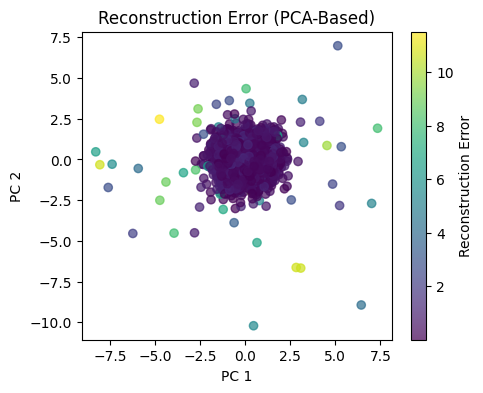

In [23]:
# Visualize reconstruction error in PCA space
plt.figure(figsize=(5, 4))
sc = plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=recon_error,
    cmap="viridis",
    alpha=0.7
)
plt.colorbar(sc, label="Reconstruction Error")
plt.title("Reconstruction Error (PCA-Based)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()


### Interpreting Reconstruction Error (PCA-Based View)

This plot visualizes **reconstruction error** for each observation,
colored by how poorly the point is reconstructed after PCA compression.

- **Darker colors** indicate *low reconstruction error*  
- **Brighter colors** indicate *high reconstruction error*

As before, the PCA projection is used **only for visualization**.
Reconstruction error itself is computed in the **original feature space**.

#### What to notice

Several patterns stand out:

- Most points in the dense central region have **low reconstruction error**
- Points farther from the core tend to have **higher reconstruction error**
- High-error points appear in multiple directions, not just one
- There is **no sharp boundary** separating normal from anomalous points

This suggests that anomalies, under this definition,
are points that **do not conform well to the dominant patterns**
learned by the PCA representation.

#### Why this happens

PCA learns a low-dimensional representation that captures
the most common variance patterns in the data.

- Points that align with these patterns reconstruct well
- Points that deviate from them lose more information during compression

High reconstruction error therefore indicates:
- poor fit to the learned representation
- atypical behavior relative to the majority of observations

Importantly, this notion of “unusual” is **pattern-based**, not distance-based.

#### How this differs from the other methods

Compared to the previous models:

- **Isolation Forest** emphasizes *separability*
- **One-Class SVM** emphasizes *boundary definition*
- **Reconstruction error** emphasizes *fit to dominant structure*

As a result:
- some points flagged here may not be flagged elsewhere
- disagreement between methods is expected and informative

#### Lab takeaway

Reconstruction-based anomaly detection provides
a **third lens** on abnormality.

Rather than asking:
> *“Is this point isolated?”*

it asks:
> *“Does this point fit the main patterns in the data?”*

In the next step, we will **apply a threshold**
to these reconstruction errors and compare
which points are ultimately flagged as anomalies.


### STOP & DISCUSS — Choosing Without Ground Truth

At the end of Step 3, we have applied **three different anomaly detection approaches**:

- Isolation Forest  
- One-Class SVM  
- Reconstruction-based (PCA)  

Each method flagged **different sets of points** as unusual.

Discuss briefly:

- Which method *felt* most reasonable so far?
- Which method would you trust **least**, and why?
- Are you more concerned about:
  - missing truly unusual points?
  - flagging too many normal points?
- If this were a real system, what would you do *next* before taking action?

At this point, there is **no ground truth**.
Any decision we make reflects assumptions, priorities, and risk tolerance.

In the next step, we will finally reveal labels
and examine how these choices affect evaluation and consequences.


### Transition

We now have **multiple anomaly detectors** — and they disagree.

In the next step, we will *finally* reveal labels
and examine how metrics compare to intuition.


## Step 4 — Evaluation (Labels Revealed)

We now reveal the **hidden fraud labels**.

This step answers an important question:
> *How well do unsupervised methods align with reality?*

⚠️ **Important:**  
Good metrics do **not** automatically imply good decisions.


In [24]:
# Convert predictions to binary (1 = anomaly, 0 = normal)
iso_bin = (iso_preds == -1).astype(int)
svm_bin = (svm_preds == -1).astype(int)

# Reconstruction-based binary decision
threshold = np.percentile(recon_error, 97)
recon_bin = (recon_error >= threshold).astype(int)


In [25]:
# Evaluation metrics
def report_metrics(y_true, y_pred, name):
    print(f"=== {name} ===")
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:   ", recall_score(y_true, y_pred))
    print("F1-score: ", f1_score(y_true, y_pred))
    print()

report_metrics(fraud_labels_hidden, iso_bin, "Isolation Forest")
report_metrics(fraud_labels_hidden, svm_bin, "One-Class SVM")
report_metrics(fraud_labels_hidden, recon_bin, "Reconstruction-Based")


=== Isolation Forest ===
Precision: 0.8833333333333333
Recall:    0.8833333333333333
F1-score:  0.8833333333333333

=== One-Class SVM ===
Precision: 0.6461538461538462
Recall:    0.7
F1-score:  0.672

=== Reconstruction-Based ===
Precision: 0.85
Recall:    0.85
F1-score:  0.85



### Interpreting the Evaluation Metrics (With Numbers)

We now evaluate each anomaly detection method using **ground-truth labels**.
This is the first point in the lab where we can quantitatively assess performance.

#### Reported results

- **Isolation Forest**
  - Precision: **0.88**
  - Recall: **0.88**
  - F1-score: **0.88**

- **One-Class SVM**
  - Precision: **0.65**
  - Recall: **0.70**
  - F1-score: **0.67**

- **Reconstruction-Based (PCA)**
  - Precision: **0.85**
  - Recall: **0.85**
  - F1-score: **0.85**

#### What the numbers tell us

Several important patterns emerge:

- **Isolation Forest performs best overall**
  - High precision and recall indicate a strong balance
  - The model flags many true anomalies while keeping false alarms relatively low

- **Reconstruction-based detection is close behind**
  - Slightly lower performance than Isolation Forest
  - Captures many of the same anomalies, but via a different definition of “unusual”

- **One-Class SVM is more conservative**
  - Lower precision suggests more false positives relative to true anomalies
  - Lower recall indicates that some true anomalies are missed
  - This reflects a tighter boundary around “normal” behavior

#### Why these differences make sense

These results align with what we observed earlier:

- **Isolation Forest**
  - Aggressive at separating rare points
  - Well-suited when anomalies are meaningfully isolated

- **Reconstruction-based methods**
  - Sensitive to deviations from dominant patterns
  - Effective when anomalies are subtle but systematic

- **One-Class SVM**
  - Strong assumptions about the shape of normal data
  - More cautious, but at the cost of missed anomalies

The metrics are not contradicting our intuition —
they are **confirming it**.

#### Precision vs. recall revisited

Even with strong overall scores, trade-offs remain:

- Isolation Forest’s higher recall means **fewer missed anomalies**
- Reconstruction-based methods provide a slightly more balanced signal
- One-Class SVM sacrifices recall for conservativeness

Which trade-off is preferable depends on context:
- fraud detection may prioritize **recall**
- systems with costly investigations may prioritize **precision**

#### Big picture takeaway

The metrics do not “pick a winner” —
they clarify **what each method is good at**.

Evaluation turns uncertainty into **informed choice**, not certainty.
The final decision still depends on:
- risk tolerance
- operational cost
- and domain priorities


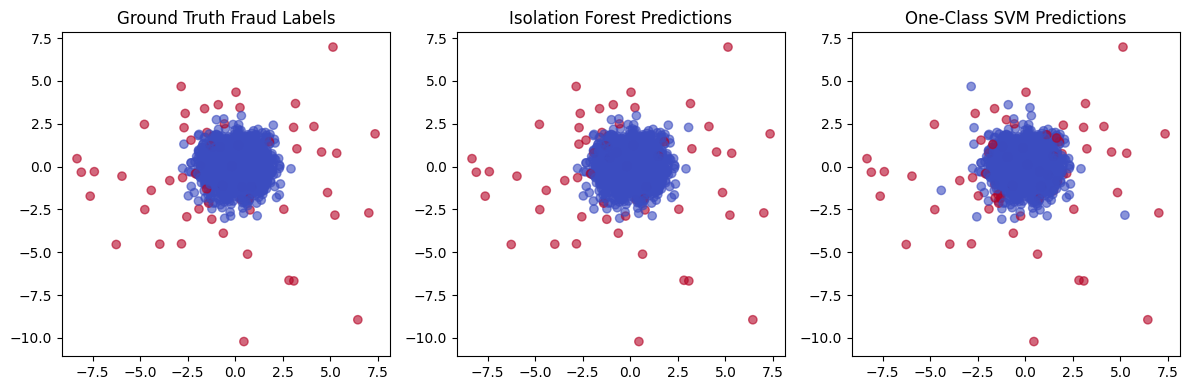

In [26]:
# Visualize true fraud cases vs predicted anomalies (PCA view)
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=fraud_labels_hidden,
    cmap="coolwarm",
    alpha=0.6
)
axes[0].set_title("Ground Truth Fraud Labels")

axes[1].scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=iso_bin,
    cmap="coolwarm",
    alpha=0.6
)
axes[1].set_title("Isolation Forest Predictions")

axes[2].scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=svm_bin,
    cmap="coolwarm",
    alpha=0.6
)
axes[2].set_title("One-Class SVM Predictions")

plt.tight_layout()
plt.show()


### Comparing Ground Truth and Model Predictions (PCA View)

This figure compares **ground-truth fraud labels** with the predictions made by
two anomaly detection models, all visualized in the same PCA space.

- **Left:** True fraud labels  
- **Middle:** Isolation Forest predictions  
- **Right:** One-Class SVM predictions  

Red points indicate fraud or predicted anomalies.
Blue points indicate normal observations.

#### What to notice

Several important patterns stand out:

- **Ground truth (left)**
  - Fraud cases are scattered around the dense central region
  - Some fraud points are far from the center, but many are embedded within it
  - There is no simple geometric rule that separates fraud from normal behavior

- **Isolation Forest (middle)**
  - Flags many points around the periphery of the data cloud
  - Captures a large fraction of true fraud cases
  - Also flags some normal points as anomalous

- **One-Class SVM (right)**
  - Flags fewer points overall
  - Misses some fraud cases that Isolation Forest captures
  - Produces fewer false alarms, but at the cost of lower recall

This visual comparison mirrors the metric results we saw earlier.

#### Why this comparison matters

Seeing predictions next to ground truth reinforces a key lesson:

> *High performance metrics do not mean perfect separation.*

Even the best-performing model:
- misses some fraud cases
- flags some normal cases
- must operate under uncertainty

The differences between the models reflect **design choices**:
- Isolation Forest prioritizes catching unusual behavior
- One-Class SVM prioritizes defining a conservative notion of “normal”

#### Lab takeaway

This comparison makes the trade-offs concrete:

- Higher recall means fewer missed fraud cases
- Higher precision means fewer false alarms
- No model achieves both perfectly

Choosing a model is therefore a **risk management decision**, not just a technical one.

At this point, the goal is not to find a perfect detector,
but to decide which behavior aligns best with the problem context.


### FINAL STOP & DISCUSS — Making the Decision

You have now seen:
- clustering that disagreed
- visualizations that suggested structure but did not resolve it
- multiple anomaly detection models with different behaviors
- evaluation metrics that revealed trade-offs, not certainty
- ground truth that confirmed imperfection

Discuss as a group:

1. **Which method would you deploy first in this scenario, and why?**
2. Which error worries you more here:
   - missing a fraud case (false negative)?
   - flagging a normal case (false positive)?
3. Would your answer change if:
   - investigations were very expensive?
   - missing a single fraud case had severe consequences?
4. What safeguards would you put in place before deploying this system?

There is no single correct answer.

The goal of unsupervised anomaly detection is not perfection —
it is **informed prioritization under uncertainty**.


## Step 5 — Reflection & Discussion

This is the most important part of the capstone, where you step back from models and
focus on **decisions, trade-offs, and context**.

### Reflection Questions

Answer these in **complete sentences**:

1. Which anomaly detection method would you trust most **in this dataset**, and why?

2. Which errors matter more here:
   - false positives (flagging normal transactions)?
   - false negatives (missing fraud)?

3. How would your preferred method change in:
   - **finance** (fraud detection)?
   - **healthcare** (disease screening)?
   - **cybersecurity** (intrusion detection)?

4. If you were deploying this system in the real world:
   - what additional data would you want?
   - what human oversight would be required?


### Final Takeaway

Unsupervised learning does not give certainty.

It gives:
- signals
- hypotheses
- priorities for investigation

The best models are not those with the highest score —
but those whose **trade-offs align with the problem context**.
